### Visualizing the distribution of the observations

### Load the required libraries

In [1]:
import pandas as pd
import numpy as np
import sklearn as sk
import urllib
import math
%pylab inline

import findspark
findspark.init()

from pyspark import SparkContext
#sc.stop()
sc = SparkContext(master="local[3]",pyFiles=['lib/numpy_pack.py','lib/spark_PCA.py','lib/computeStats.py'])

from pyspark import SparkContext
from pyspark.sql import *
sqlContext = SQLContext(sc)

import sys
sys.path.append('./lib')

import numpy as np
from numpy_pack import packArray,unpackArray
from spark_PCA import computeCov
from computeStats import computeOverAllDist, STAT_Descriptions

### Read the data frame from pickle file

data_dir='../../Data/Weather'
#file_index='BBBSBBBB'
file_index='SSSBSSSS'
from pickle import load

#read statistics
filename=data_dir+'/STAT_%s.pickle'%file_index
STAT,STAT_Descriptions = load(open(filename,'rb'))
print 'keys from STAT=',STAT.keys()

#read data
filename=data_dir+'/US_Weather_%s.parquet'%file_index

df=sqlContext.read.parquet(filename)
print df.count()
df.show(5)

Populating the interactive namespace from numpy and matplotlib
keys from STAT= ['TMIN', 'TOBS', 'TMAX', 'SNOW', 'SNWD', 'PRCP']
12741
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|elevation|latitude|longitude|measurement|    station|undefs|              vector|  year|   label|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|    402.9| 36.4708|-121.1472|       TMAX|USR0000CPNN|     2|[-72, 89, 0, 88, ...|2002.0|SSSBSSSS|
|    402.9| 36.4708|-121.1472|       TMAX|USR0000CPNN|     2|[-112, 89, 16, 90...|2003.0|SSSBSSSS|
|    402.9| 36.4708|-121.1472|       TMAX|USR0000CPNN|     1|[-32, 85, 0, 88, ...|2004.0|SSSBSSSS|
|    402.9| 36.4708|-121.1472|       TMAX|USR0000CPNN|     2|[80, 87, -112, 85...|2005.0|SSSBSSSS|
|    402.9| 36.4708|-121.1472|       TMAX|USR0000CPNN|     7|[-96, 86, -16, 86...|2006.0|SSSBSSSS|
+---------+--------+---------+-----------+-----------+------+-------------

In [2]:
print filename


../../Data/Weather/US_Weather_SSSBSSSS.parquet


### Select data for a particular station and measurement type

In [3]:
sqlContext.registerDataFrameAsTable(df,'weather')

#Query="SELECT * FROM weather\n\tWHERE measurement='%s' and station='%s'"%('PRCP','USC00198301')
Query="SELECT * FROM weather\n\tWHERE measurement='%s' and station='%s'"%('PRCP','USC00043004')
#Query="SELECT * FROM weather\n\tWHERE measurement='%s' and station='%s'"%('PRCP','USC00045120')
# print Query
# Query="SELECT station, count(*) station FROM weather\n\tWHERE measurement='%s' group by station"%('PRCP')
print Query
df1 = sqlContext.sql(Query)
print df1.count(),'rows'
df1.show(8)
rows=df1.rdd.map(lambda row:unpackArray(row['vector'],np.float16)).collect()
T=np.vstack(rows)
T=T/10.  # scaling to make the temperature be in centingrates
shape(T)

SELECT * FROM weather
	WHERE measurement='PRCP' and station='USC00043004'
7 rows
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|elevation|latitude|longitude|measurement|    station|undefs|              vector|  year|   label|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|    121.9| 37.0506| -122.075|       PRCP|USC00043004|    33|[0, 0, 0, 66, 0, ...|2001.0|SSSBSSSS|
|    121.9| 37.0506| -122.075|       PRCP|USC00043004|    34|[0, 126, -24, 90,...|2002.0|SSSBSSSS|
|    121.9| 37.0506| -122.075|       PRCP|USC00043004|    33|[0, 0, 0, 0, 0, 0...|2003.0|SSSBSSSS|
|    121.9| 37.0506| -122.075|       PRCP|USC00043004|     2|[96, 82, 96, 81, ...|2004.0|SSSBSSSS|
|    121.9| 37.0506| -122.075|       PRCP|USC00043004|     3|[-16, 91, -4, 94,...|2005.0|SSSBSSSS|
|    121.9| 37.0506| -122.075|       PRCP|USC00043004|     2|[68, 96, 32, 90, ...|2006.0|SSSBSSSS|
|    121.9| 37.0506| -122.07

(7, 365)

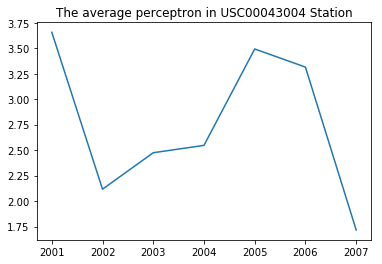

In [4]:
meanYear = [np.nanmean(x) for x in T]
import matplotlib.pyplot as plt
x = ['2001', '2002', '2003', '2004', '2005', '2006', '2007']
plt.plot(x, meanYear)
plt.title('The average perceptron in USC00043004 Station')
plt.show()

<type 'list'>
12
<type 'list'>
12
<type 'list'>
12
<type 'list'>
12
<type 'list'>
12
<type 'list'>
12
<type 'list'>
12


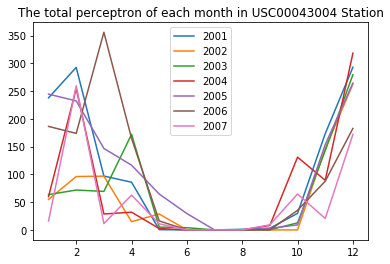

In [5]:
def generateToMonth(x, isFour):
    res = []
    num = 0
    x = list(x)
    print type(x)
    for i in range(12):
        if i == 0 or i == 2 or i == 4 or i == 6 or i == 7 or i == 9 or i == 11:
            res += np.nansum(x[num : num + 31]),
            num += 31
        elif i == 2:
            if not isFour:
                res += np.nansum(x[num : num + 28]),
                num += 28
            else:
                res += np.nansum(x[num : num + 29]),
                num += 29
        else:
            res += np.nansum(x[num : num + 30]),
            num += 30
    print len(res)
    return res
months = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12']
month_value = [generateToMonth(T[i], i % 4) for i in range(len(T))]
plt.plot(months, month_value[0])
plt.plot(months, month_value[1])
plt.plot(months, month_value[2])
plt.plot(months, month_value[3])
plt.plot(months, month_value[4])
plt.plot(months, month_value[5])
plt.plot(months, month_value[6])
plt.legend([str(i) for i in range(2001, 2008)])
plt.title('The total perceptron of each month in USC00043004 Station')
plt.show()

In [6]:
import scipy.stats as stats  
for i in range(7):
    print str(i+2001), 'p-value = ', stats.chisquare(month_value[i])[1]
print meanYear
print np.corrcoef(month_value)

print 'total', 'p-value = ', stats.chisquare(meanYear)[1]

2001 p-value =  0.0
2002 p-value =  4.62741329997e-258
2003 p-value =  3.09997656337e-263
2004 p-value =  0.0
2005 p-value =  5.88093258247e-226
2006 p-value =  1.00453501891e-294
2007 p-value =  2.71318622523e-294
[3.6562, 2.1172, 2.4746, 2.5469, 3.4922, 3.3145, 1.7178]
[[ 1.          0.79289517  0.71050383  0.81862207  0.95948793  0.62665078
   0.74361184]
 [ 0.79289517  1.          0.83885772  0.77507003  0.78904396  0.54480185
   0.54662389]
 [ 0.71050383  0.83885772  1.          0.66997515  0.72907699  0.53752041
   0.50610498]
 [ 0.81862207  0.77507003  0.66997515  1.          0.69786687  0.36774301
   0.89882575]
 [ 0.95948793  0.78904396  0.72907699  0.69786687  1.          0.73941299
   0.62373377]
 [ 0.62665078  0.54480185  0.53752041  0.36774301  0.73941299  1.
   0.34771956]
 [ 0.74361184  0.54662389  0.50610498  0.89882575  0.62373377  0.34771956
   1.        ]]
total p-value =  0.97754512736


### Script for plotting yearly plots

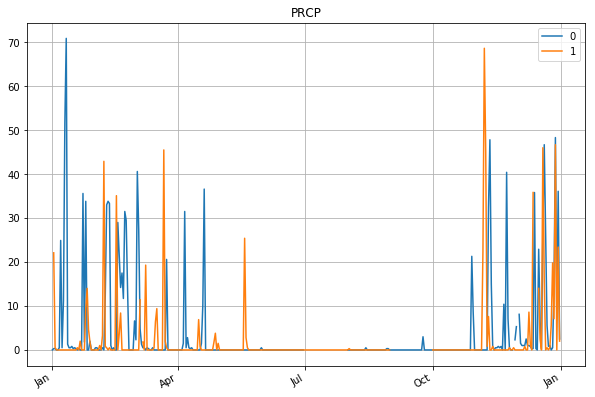

In [7]:
from YearPlotter import YearPlotter
fig, ax = plt.subplots(figsize=(10,7));
YP=YearPlotter()
YP.plot(T[:2,:].transpose(),fig,ax,title='PRCP',labels = ['0','1'])

#title('A sample of graphs');

### Distribution of missing observations
The distribution of missing observations is not uniform throughout the year. We visualize it below.

In [9]:
def plot_pair(pair,func, labels):
    j=0
    fig,X=subplots(1,2,figsize=(16,6))
    axes=X.reshape(2)
    for m in pair:
        axis = axes[j]
        j+=1
        func(m,fig,axis, labels)
        
def plot_valid(m,fig,axis, labels):
    valid_m=STAT[m]['NE']
    YP.plot(valid_m,fig,axis,labels, title='valid-counts '+m)
    

[3.6562, 2.1172, 2.4746, 2.5469, 3.4922, 3.3145, 1.7178]
[[ 1.          0.86326397  0.73808961  0.39724766  0.49854135  0.34805263]
 [ 0.86326397  1.          0.68633115  0.2955612   0.34238129  0.28282902]
 [ 0.73808961  0.68633115  1.          0.28384152  0.25010047  0.20606772]
 [ 0.39724766  0.2955612   0.28384152  1.          0.59467655  0.60439362]
 [ 0.49854135  0.34238129  0.25010047  0.59467655  1.          0.5577633 ]
 [ 0.34805263  0.28282902  0.20606772  0.60439362  0.5577633   1.        ]]
[[ 1.    0.86  0.74  0.4   0.5   0.35]
 [ 0.86  1.    0.69  0.3   0.34  0.28]
 [ 0.74  0.69  1.    0.28  0.25  0.21]
 [ 0.4   0.3   0.28  1.    0.59  0.6 ]
 [ 0.5   0.34  0.25  0.59  1.    0.56]
 [ 0.35  0.28  0.21  0.6   0.56  1.  ]]


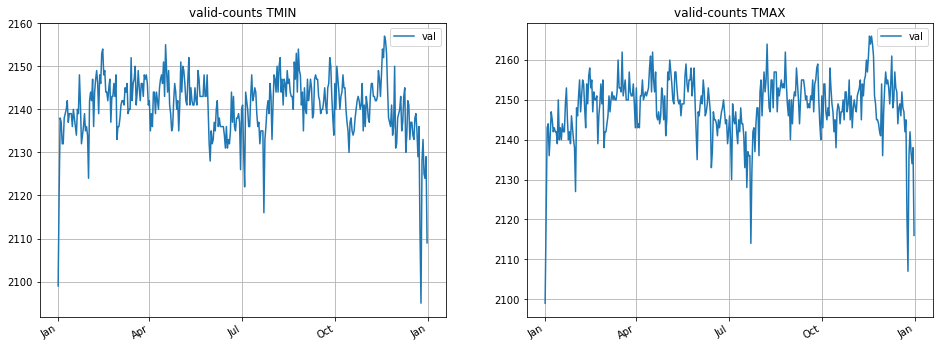

In [13]:
plot_pair(['TMIN','TMAX'],plot_valid, 'val')
print meanYear
NEtable = [STAT['TMIN']['NE'], STAT['TMAX']['NE'], STAT['TOBS']['NE'], STAT['PRCP']['NE'], 
        STAT['SNOW']['NE'], STAT['SNWD']['NE'] ]
print np.corrcoef(NEtable)

NEtable = np.corrcoef(NEtable)
print np.around(NEtable, decimals = 2)

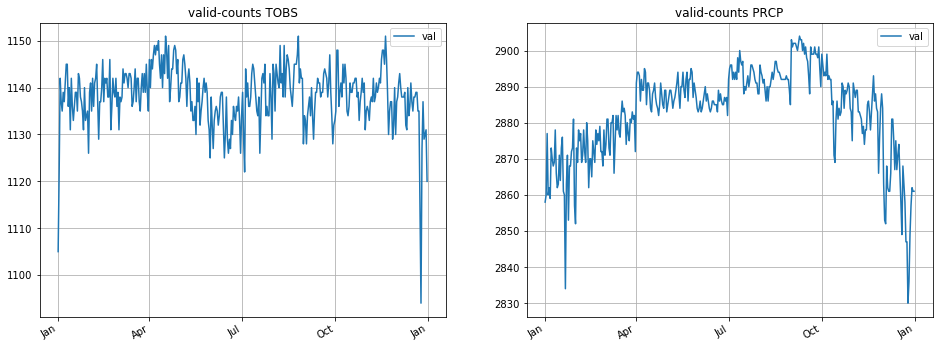

In [15]:
plot_pair(['TOBS','PRCP'],plot_valid, 'val')

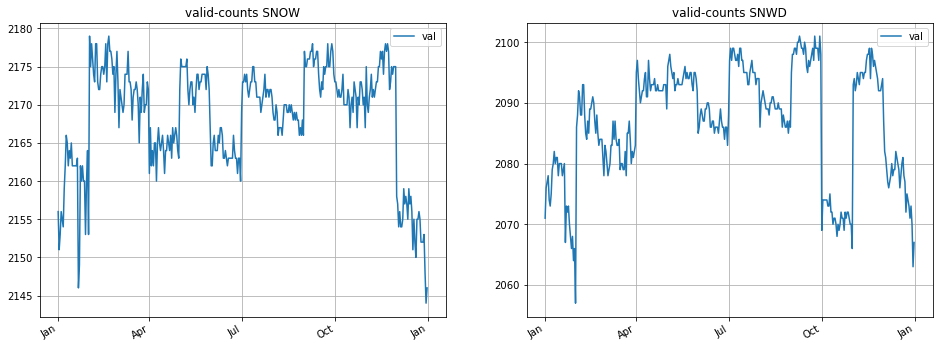

In [14]:
plot_pair(['SNOW', 'SNWD'],plot_valid, 'val')

### Plots of mean and std of observations

In [40]:
def plot_mean_std(m,fig,axis, labels):
    mean=STAT[m]['Mean']
    std=np.sqrt(STAT[m]['Var'])
    graphs=np.vstack([mean-std,mean,mean+std]).transpose()
    print labels
    YP.plot(graphs,fig,axis,
            title='Mean+-std   '+m, labels = labels)

['mean-std', 'mean', 'mean + std']
['mean-std', 'mean', 'mean + std']


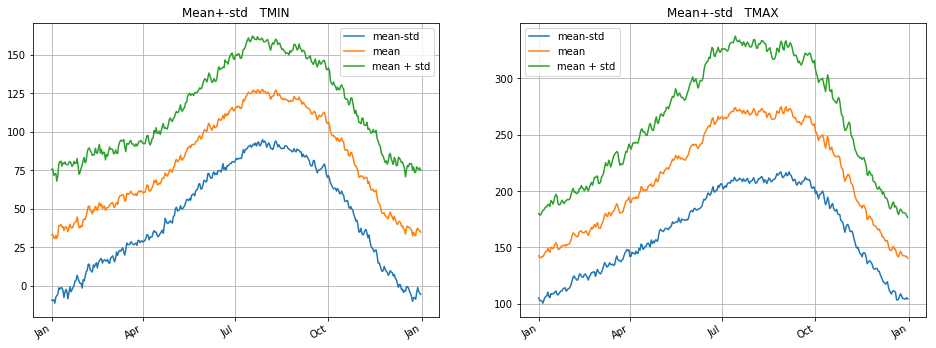

In [41]:
plot_pair(['TMIN','TMAX'],plot_mean_std, ['mean-std', 'mean', 'mean + std'])

['mean-std', 'mean', 'mean + std']
['mean-std', 'mean', 'mean + std']


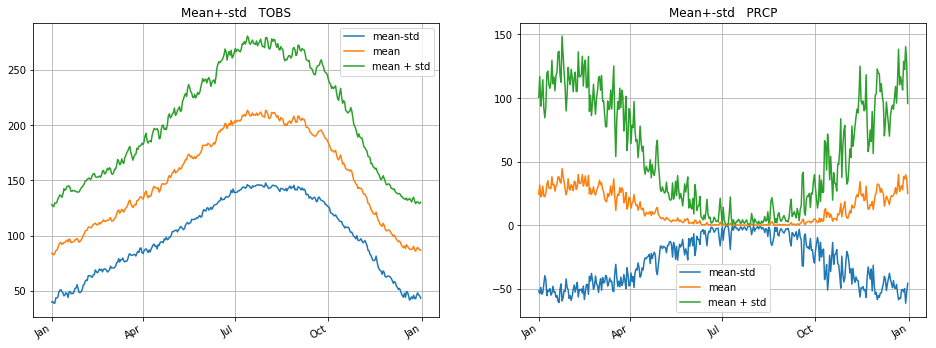

In [42]:
plot_pair(['TOBS','PRCP'],plot_mean_std, ['mean-std', 'mean', 'mean + std'])

['mean-std', 'mean', 'mean + std']
['mean-std', 'mean', 'mean + std']


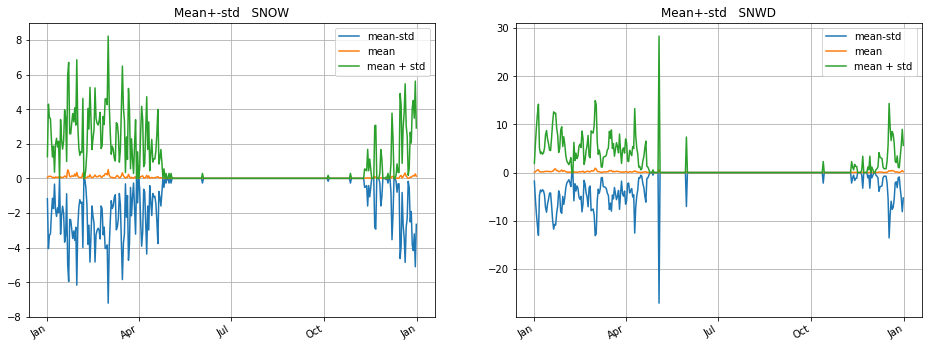

In [43]:
plot_pair(['SNOW', 'SNWD'],plot_mean_std, ['mean-std', 'mean', 'mean + std'])

### plotting top 3 eigenvectors

In [49]:
def plot_eigen(m,fig,axis, labels):
    EV=STAT[m]['eigvec']
    YP.plot(EV[:,:3],fig,axis,title='Top Eigenvectors '+m, labels = labels)

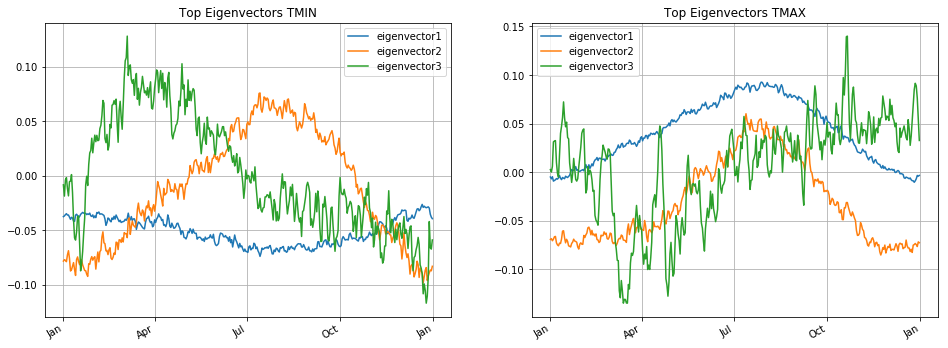

In [50]:
plot_pair(['TMIN','TMAX'],plot_eigen, ['eigenvector1', 'eigenvector2', 'eigenvector3'])

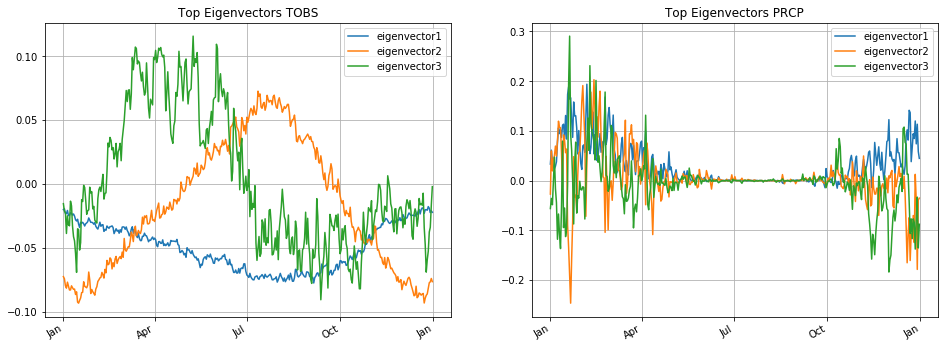

In [51]:
plot_pair(['TOBS','PRCP'],plot_eigen, ['eigenvector1', 'eigenvector2', 'eigenvector3'])

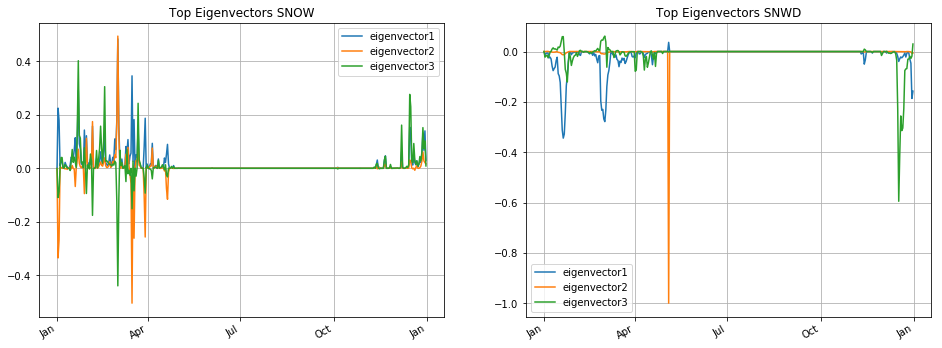

In [52]:
plot_pair(['SNOW', 'SNWD'],plot_eigen, ['eigenvector1', 'eigenvector2', 'eigenvector3'])

### Script for plotting percentage of variance explained

In [53]:
def pltVarExplained(j):
    subplot(1,3,j)
    EV=STAT[m]['eigval']
    k=5
    plot(([0,]+list(cumsum(EV[:k])))/sum(EV))
    title('Percentage of Variance Explained for '+ m)
    ylabel('Percentage of Variance')
    xlabel('# Eigenvector')
    grid()
    

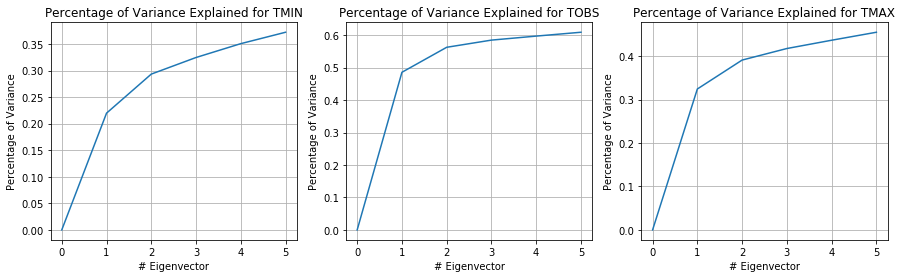

In [54]:
f=plt.figure(figsize=(15,4))
j=1
for m in ['TMIN', 'TOBS', 'TMAX']: #,
    pltVarExplained(j)
    j+=1

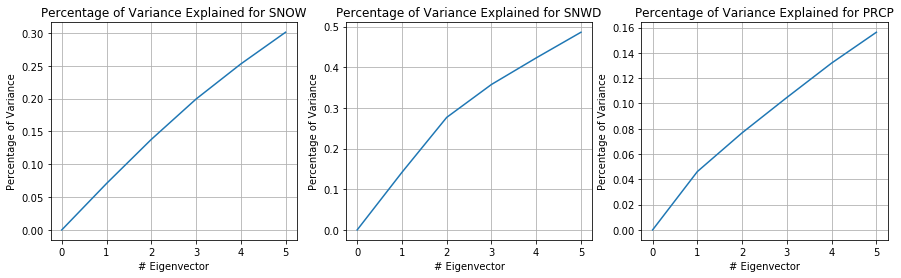

In [55]:
f=plt.figure(figsize=(15,4))
j=1
for m in ['SNOW', 'SNWD', 'PRCP']:
    pltVarExplained(j)
    j+=1 

In [ ]:
#sc.stop()